In [1]:
import alphashape
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import rasterio
import rioxarray
import seaborn as sns
#import xarray as xr

from lightgbm import LGBMRegressor 
from rasterio.plot import show
from rasterio.features import rasterize, shapes
from rasterio.transform import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.spatial import cKDTree

from sklearn import preprocessing
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler     
from sklearn.ensemble import RandomForestRegressor  
from sklearn.linear_model import LinearRegression               
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

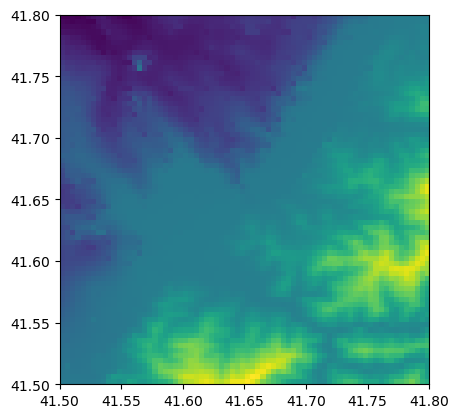

<Axes: >

In [2]:
geotif_depth = 'gebco_2024_n41.8_s41.5_w41.5_e41.8.tif'
src = rasterio.open(geotif_depth)
show(src)

In [3]:
src.crs

CRS.from_epsg(4326)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


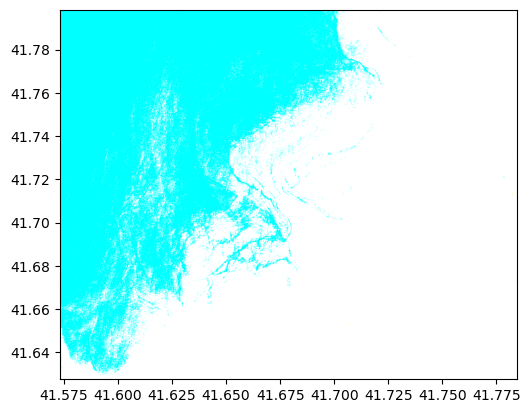

CRS.from_epsg(4326)

In [4]:
geotif1 = '2024-05-18-00_00_2024-05-18-23_59_Sentinel-2_L1C_True_color.tiff'
src = rasterio.open(geotif1)
show(src)
src.crs

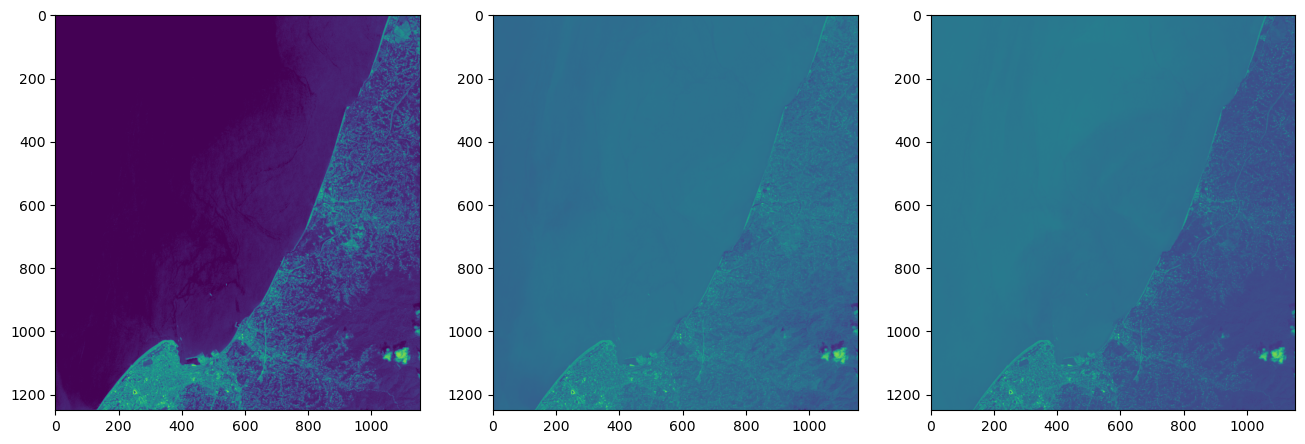

In [5]:
plt.figure(figsize=(16,8))

for i in range(1,4):
    array = src.read(i)
    plt.subplot(1,3,i)
    plt.imshow(array, cmap='viridis')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


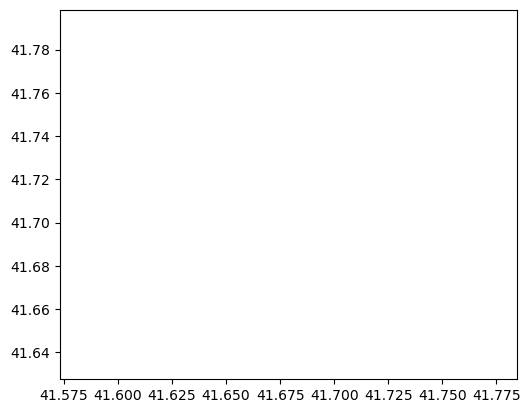

<Axes: >

In [6]:
geotif2 = '2024-05-18-00_00_2024-05-18-23_59_Sentinel-2_L1C_False_Color.tiff'
src = rasterio.open(geotif2)
show(src)

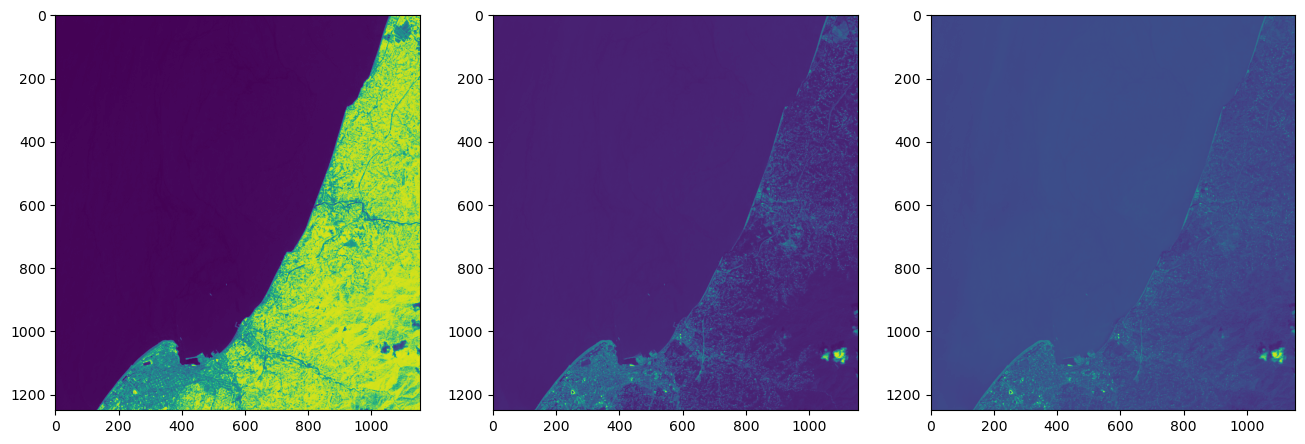

In [7]:
plt.figure(figsize=(16,8))

for i in range(1,4):
    array = src.read(i)
    plt.subplot(1,3,i)
    plt.imshow(array, cmap='viridis')

In [8]:
# i prepared this function for make additional features from satellite channels with approach similar to pooing
# every window 3x3 will take values from its max, mean or sqare root
def max_pool(array, func='max'):
    array_proc = np.zeros(array.shape)
    start_x=0
    stride_x = 3
    stride_y = 3
    for i in range(0, int(array.shape[0] // 3 )):
        start_y=0
        for a in range(0, int(array.shape[1] // 3 )):
            step = array[start_x:start_x+stride_x,start_y:start_y+stride_y]
            if func == 'max':
                array_proc[start_x:start_x+stride_x,start_y:start_y+stride_y] = np.max(step)
            elif func == 'mean':
                array_proc[start_x:start_x+stride_x,start_y:start_y+stride_y] = np.mean(step)
            else:
                array_proc[start_x:start_x+stride_x,start_y:start_y+stride_y] = np.sqrt(step)
            start_y += stride_y
        start_x += stride_x
    return(array_proc)

In [9]:
# fuction to make datafile with coordinates and depth or satellite channels
# also this function will add "pool" features from previous function
# due to adding features from 2 images it is possible to set number of columns
def geotiff_to_xyz(way, func='max', start_output_col=0):
    dataarray = rioxarray.open_rasterio(way)
    for i in range(0,3):
        if i == 0:
            df = dataarray[i].to_pandas()
            lat = pd.Series(pd.to_numeric(list(df.index) * df.shape[1])).sort_values(ascending=False)
            lon = pd.to_numeric(list(df.columns) * df.shape[0])
            depth = df.values.flatten()
            try:
                depth_mp = max_pool(df.values, func).flatten()
                ds = pd.DataFrame({'lat': lat, 'lon': lon, str(start_output_col+i): depth, str(str(start_output_col+i)+func): depth_mp})
            except:
                ds = pd.DataFrame({'lat': lat, 'lon': lon, str(start_output_col+i): depth})
        else:
            try:
                df = dataarray[i].to_pandas()
                depth = df.values.flatten()
                depth_mp = max_pool(df.values, func).flatten()
                ds[str(start_output_col+i)] = depth
                ds[str(str(start_output_col+i)+func)] = depth_mp
            except:
                print('no channel')
            
    return ds

In [10]:
# this is first aplication of function to perform tiff to table
# result is a geojson with depth points 
depth_gebco = geotiff_to_xyz(geotif_depth)
depth_gebco = depth_gebco.rename(columns = {'0':'depth'})
depth_gebco = depth_gebco.loc[(depth_gebco['depth'] <= -0.5) & (depth_gebco['depth'] >= -15)]
depth_gebco = depth_gebco.loc[(depth_gebco['lat'] > 41.625) & (depth_gebco['lon'] >= 41.57)]
depth_gebco = gpd.GeoDataFrame(
    depth_gebco, geometry=gpd.points_from_xy(depth_gebco.lon, depth_gebco.lat), crs="EPSG:4326"
)
depth_gebco.to_file('gebco_points_15.geojson', driver="GeoJSON")
depth_gebco.head()

no channel
no channel


lat        lon  depth  0max                   geometry
3384  41.797917  41.760417    -11 -10.0  POINT (41.76042 41.79792)
3888  41.797917  41.764583     -5   4.0  POINT (41.76458 41.79792)
3456  41.797917  41.768750     -9   4.0  POINT (41.76875 41.79792)
3313  41.793750  41.760417    -10 -10.0  POINT (41.76042 41.79375)
3817  41.793750  41.764583    -11   4.0  POINT (41.76458 41.79375)

In [11]:
# this was first approach to obtain multipolygon for selected area 
# i tried use it for cropping images and bathymetry to selected area
# but detalization wasn`t good and i made multipolygon for selected area manualy using QGIS

# create a concave hull with an alpha parameter (from 0 = detailed to 1 = convex)
alpha_shape = alphashape.alphashape(depth_gebco.geometry, alpha=0)

# convert to gdf
concave_hull_gdf = gpd.GeoDataFrame(geometry=[alpha_shape], crs=depth_gebco.crs)

# gdf with selected area
concave_hull_gdf.to_file('bs_east_0-15_area.geojson', driver="GeoJSON")

In [12]:
# load multipolygon for selected area prepared using QGIS
area = gpd.read_file('work_area_polygon2.geojson')
area

id                                           geometry
0   1  MULTIPOLYGON (((41.64841 41.66490, 41.65680 41...

In [13]:
# load multiline with coastline prepared using QGIS
coastline = gpd.read_file('coastline.geojson')
coastline

id                                           geometry
0   1  MULTILINESTRING ((41.62358 41.65108, 41.62749 ...

In [14]:
# crop satellite image 1 to area
from rasterio.mask import mask

# Open the raster
with rasterio.open(geotif1) as src:
    out_image, out_transform = mask(src, area.geometry, crop=True)
    
    # Save cropped raster
    out_meta = src.meta
    out_meta.update({"transform": out_transform, "height": out_image.shape[1], "width": out_image.shape[2]})
    
    with rasterio.open("satelite1.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [15]:
# crop satellite image 2 to area
with rasterio.open(geotif2) as src:
    out_image, out_transform = mask(src, area.geometry, crop=True)
    
    # Save cropped raster
    out_meta = src.meta
    out_meta.update({"transform": out_transform, "height": out_image.shape[1], "width": out_image.shape[2]})
    
    with rasterio.open("satelite2.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [16]:
# crop bathymetry to area (additional for full compliance)
with rasterio.open(geotif_depth) as src:
    out_image, out_transform = mask(src, area.geometry, crop=True)
    
    # Save cropped raster
    out_meta = src.meta
    out_meta.update({"transform": out_transform, "height": out_image.shape[1], "width": out_image.shape[2]})
    
    with rasterio.open("depth_croped.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [17]:
# data with depth
depth_gebco = geotiff_to_xyz('depth_croped.tif')
depth_gebco = depth_gebco.rename(columns = {'0':'depth'})
depth_gebco = depth_gebco.loc[(depth_gebco['depth'] <= -0.5) & (depth_gebco['depth'] >= -15)]
depth_gebco

no channel
no channel


lat        lon  depth  0max
1044  41.797917  41.760417    -11  -5.0
72    41.797917  41.764583     -5  -5.0
433   41.793750  41.760417    -10  -5.0
578   41.789583  41.752083    -14 -14.0
362   41.789583  41.756250    -15 -14.0
...         ...        ...    ...   ...
970   41.656250  41.656250    -14  -9.0
862   41.656250  41.660417     -7  -6.0
214   41.656250  41.664583     -7  -6.0
1078  41.656250  41.668750     -7  -6.0
899   41.652083  41.660417     -6  -6.0

[151 rows x 4 columns]

In [18]:
# opening satellite images with adding additional features

sat_images_paths_list = ["satelite1.tif", "satelite1.tif"]
start_output_col = 0
start=0

for i in sat_images_paths_list:
    data = geotiff_to_xyz(i, start_output_col=start_output_col)

    if start == 1:
        for iter in data.columns.drop(['lat','lon']).to_list():
            satelite[iter] = data[iter]

    if start == 0:
        satelite = data.copy()
        start = 1

    for f in ['sqrt', 'mean']:
        data = geotiff_to_xyz(i, f, start_output_col=start_output_col)
        for iter in data.columns.drop(['lat','lon']).to_list():
            satelite[iter] = data[iter]
    start_output_col +=3

print(satelite.shape)
satelite.head()

(696819, 26)


lat        lon  0  0max  1  1max  2  2max  0sqrt  1sqrt  ...  4  \
0       41.79838  41.648365  0   0.0  0   0.0  0   0.0    0.0    0.0  ...  0   
87237   41.79838  41.648549  0   0.0  0   0.0  0   0.0    0.0    0.0  ...  0   
562194  41.79838  41.648732  0   0.0  0   0.0  0   0.0    0.0    0.0  ...  0   
134625  41.79838  41.648915  0   0.0  0   0.0  0   0.0    0.0    0.0  ...  0   
421107  41.79838  41.649098  0   0.0  0   0.0  0   0.0    0.0    0.0  ...  0   

        4max  5  5max  3sqrt  4sqrt  5sqrt  3mean  4mean  5mean  
0        0.0  0   0.0    0.0    0.0    0.0    0.0    0.0    0.0  
87237    0.0  0   0.0    0.0    0.0    0.0    0.0    0.0    0.0  
562194   0.0  0   0.0    0.0    0.0    0.0    0.0    0.0    0.0  
134625   0.0  0   0.0    0.0    0.0    0.0    0.0    0.0    0.0  
421107   0.0  0   0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 26 columns]

In [19]:
satelite = satelite.map(lambda x: x if x > 0 else None)

In [20]:
satelite = satelite.dropna()
satelite.head()

lat        lon       0    0max        1     1max        2  \
113085  41.79838  41.759973  8112.0  8112.0  24117.0  24621.0  23651.0   
368334  41.79838  41.760156  6971.0  8112.0  24325.0  24621.0  24268.0   
595581  41.79838  41.760340  8110.0  8112.0  24095.0  24621.0  23892.0   
578349  41.79838  41.760523  6670.0  8020.0  24169.0  24476.0  24054.0   
260634  41.79838  41.760706  8020.0  8020.0  24217.0  24476.0  23429.0   

           2max      0sqrt       1sqrt  ...        4     4max        5  \
113085  24268.0  90.066643  155.296494  ...  24117.0  24621.0  23651.0   
368334  24268.0  83.492516  155.964737  ...  24325.0  24621.0  24268.0   
595581  24268.0  90.055542  155.225647  ...  24095.0  24621.0  23892.0   
578349  24609.0  81.670067  155.463821  ...  24169.0  24476.0  24054.0   
260634  24609.0  89.554451  155.618118  ...  24217.0  24476.0  23429.0   

           5max      3sqrt       4sqrt       5sqrt        3mean         4mean  \
113085  24268.0  90.066643  155.296494  153.788818  7732.666667  24257.333333   
368334  24268.0  83.492516  155.964737  155.781906  7732.666667  24257.333333   
595581  24268.0  90.055542  155.225647  154.570374  7732.666667  24257.333333   
578349  24609.0  81.670067  155.463821  155.093521  7168.222222  24199.444444   
260634  24609.0  89.554451  155.618118  153.065338  7168.222222  24199.444444   

               5mean  
113085  23930.111111  
368334  23930.111111  
595581  23930.111111  
578349  24085.777778  
260634  24085.777778  

[5 rows x 26 columns]

In [21]:
print(depth_gebco)

            lat        lon  depth  0max
1044  41.797917  41.760417    -11  -5.0
72    41.797917  41.764583     -5  -5.0
433   41.793750  41.760417    -10  -5.0
578   41.789583  41.752083    -14 -14.0
362   41.789583  41.756250    -15 -14.0
...         ...        ...    ...   ...
970   41.656250  41.656250    -14  -9.0
862   41.656250  41.660417     -7  -6.0
214   41.656250  41.664583     -7  -6.0
1078  41.656250  41.668750     -7  -6.0
899   41.652083  41.660417     -6  -6.0

[151 rows x 4 columns]


Then i want to transfer depth points from gebco grid to grid of satellite images to make possible feature model in one grid

In [22]:
# i wanted to divide train and test subsets at this stage but now i want use another approach (but will keep this code)
'''
depth_train, depth_test = train_test_split(depth_gebco, test_size=0.2, random_state=12345)

# transfer train points to satellite
coarse_points = np.c_[depth_train.lon.ravel(), depth_train.lat.ravel()]
fine_points = np.c_[satelite.lon.ravel(), satelite.lat.ravel()]

tree = cKDTree(coarse_points)
max_distance = 0.00075

distances, indices = tree.query(fine_points, distance_upper_bound=max_distance)
fine_values = np.full(fine_points.shape[0], np.nan)
valid_mask = distances < max_distance
fine_values[valid_mask] = depth_train.depth.ravel()[indices[valid_mask]]
fine_values_grid_train = fine_values.reshape(satelite.lon.shape)

# transfer test points to satellite
coarse_points = np.c_[depth_test.lon.ravel(), depth_test.lat.ravel()]
fine_points = np.c_[satelite.lon.ravel(), satelite.lat.ravel()]

tree = cKDTree(coarse_points)
max_distance = 0.00075

distances, indices = tree.query(fine_points, distance_upper_bound=max_distance)
fine_values = np.full(fine_points.shape[0], np.nan)
valid_mask = distances < max_distance
fine_values[valid_mask] = depth_test.depth.ravel()[indices[valid_mask]]
fine_values_grid_test = fine_values.reshape(satelite.lon.shape)

united = satelite.copy()
united['depth'] = fine_values_grid_train
united['depth_test'] = fine_values_grid_test
united.info()
'''

"\ndepth_train, depth_test = train_test_split(depth_gebco, test_size=0.2, random_state=12345)\n\n# transfer train points to satellite\ncoarse_points = np.c_[depth_train.lon.ravel(), depth_train.lat.ravel()]\nfine_points = np.c_[satelite.lon.ravel(), satelite.lat.ravel()]\n\ntree = cKDTree(coarse_points)\nmax_distance = 0.00075\n\ndistances, indices = tree.query(fine_points, distance_upper_bound=max_distance)\nfine_values = np.full(fine_points.shape[0], np.nan)\nvalid_mask = distances < max_distance\nfine_values[valid_mask] = depth_train.depth.ravel()[indices[valid_mask]]\nfine_values_grid_train = fine_values.reshape(satelite.lon.shape)\n\n# transfer test points to satellite\ncoarse_points = np.c_[depth_test.lon.ravel(), depth_test.lat.ravel()]\nfine_points = np.c_[satelite.lon.ravel(), satelite.lat.ravel()]\n\ntree = cKDTree(coarse_points)\nmax_distance = 0.00075\n\ndistances, indices = tree.query(fine_points, distance_upper_bound=max_distance)\nfine_values = np.full(fine_points.shape[

In [23]:
# approach with split data independent to depth_gebco
coarse_points = np.c_[depth_gebco.lon.ravel(), depth_gebco.lat.ravel()]
fine_points = np.c_[satelite.lon.ravel(), satelite.lat.ravel()]

tree = cKDTree(coarse_points)

# distance to gebko points in case of which points from satellite image will be assigned depth of gebko points

# this is key point in this project. The size of the training sample depends on how many points from the satellite 
# grid will be assigned depth values from the gebko grid. 
# If the distance is too large (and more points will be assigned values from the gebko grid), 
# the result will be less valid. In addition, if a sequential neural network is used, 
# the model is well trained (and retrained) and the result looks unnatural (all training points are predicted by gebko grid values).

max_distance = 0.0005

distances, indices = tree.query(fine_points, distance_upper_bound=max_distance)
fine_values = np.full(fine_points.shape[0], np.nan)
valid_mask = distances < max_distance
fine_values[valid_mask] = depth_gebco.depth.ravel()[indices[valid_mask]]
fine_values_grid = fine_values.reshape(satelite.lon.shape)

united = satelite.copy()
united['depth'] = fine_values_grid
united.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122093 entries, 113085 to 488956
Data columns (total 27 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     122093 non-null  float64
 1   lon     122093 non-null  float64
 2   0       122093 non-null  float64
 3   0max    122093 non-null  float64
 4   1       122093 non-null  float64
 5   1max    122093 non-null  float64
 6   2       122093 non-null  float64
 7   2max    122093 non-null  float64
 8   0sqrt   122093 non-null  float64
 9   1sqrt   122093 non-null  float64
 10  2sqrt   122093 non-null  float64
 11  0mean   122093 non-null  float64
 12  1mean   122093 non-null  float64
 13  2mean   122093 non-null  float64
 14  3       122093 non-null  float64
 15  3max    122093 non-null  float64
 16  4       122093 non-null  float64
 17  4max    122093 non-null  float64
 18  5       122093 non-null  float64
 19  5max    122093 non-null  float64
 20  3sqrt   122093 non-null  float64
 21  4sqrt   12

In [24]:
# make gdf to count distance to coastline (this will not use in this file)
united = gpd.GeoDataFrame(united, geometry=gpd.points_from_xy(united.lon, united.lat), crs="EPSG:4326")
united.head()

lat        lon       0    0max        1     1max        2  \
113085  41.79838  41.759973  8112.0  8112.0  24117.0  24621.0  23651.0   
368334  41.79838  41.760156  6971.0  8112.0  24325.0  24621.0  24268.0   
595581  41.79838  41.760340  8110.0  8112.0  24095.0  24621.0  23892.0   
578349  41.79838  41.760523  6670.0  8020.0  24169.0  24476.0  24054.0   
260634  41.79838  41.760706  8020.0  8020.0  24217.0  24476.0  23429.0   

           2max      0sqrt       1sqrt  ...        5     5max      3sqrt  \
113085  24268.0  90.066643  155.296494  ...  23651.0  24268.0  90.066643   
368334  24268.0  83.492516  155.964737  ...  24268.0  24268.0  83.492516   
595581  24268.0  90.055542  155.225647  ...  23892.0  24268.0  90.055542   
578349  24609.0  81.670067  155.463821  ...  24054.0  24609.0  81.670067   
260634  24609.0  89.554451  155.618118  ...  23429.0  24609.0  89.554451   

             4sqrt       5sqrt        3mean         4mean         5mean  \
113085  155.296494  153.788818  7732.666667  24257.333333  23930.111111   
368334  155.964737  155.781906  7732.666667  24257.333333  23930.111111   
595581  155.225647  154.570374  7732.666667  24257.333333  23930.111111   
578349  155.463821  155.093521  7168.222222  24199.444444  24085.777778   
260634  155.618118  153.065338  7168.222222  24199.444444  24085.777778   

        depth                   geometry  
113085    NaN  POINT (41.75997 41.79838)  
368334    NaN  POINT (41.76016 41.79838)  
595581  -11.0  POINT (41.76034 41.79838)  
578349  -11.0  POINT (41.76052 41.79838)  
260634    NaN  POINT (41.76071 41.79838)  

[5 rows x 28 columns]

In [25]:
united['distance_to_coast'] = united['geometry'].to_crs(3857).distance(coastline['geometry'].to_crs(3857)[0])

<Axes: >

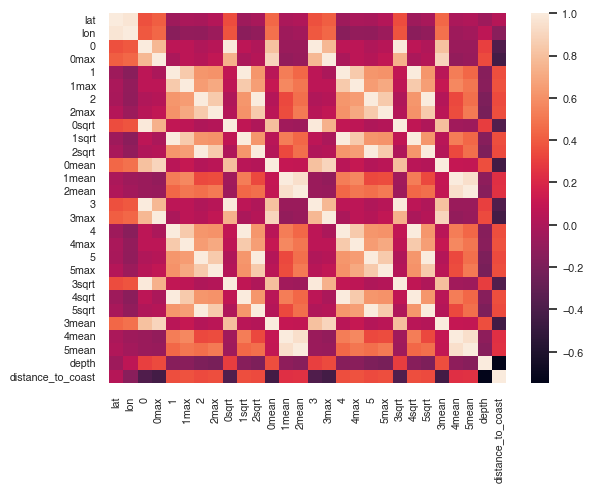

In [26]:
# look on heatmap of the correlations
sns.set_theme(font='helvetica', font_scale=0.7)
sns.heatmap(united.drop(['geometry'],axis=1).dropna().corr())
#sns.heatmap(united.drop(['geometry','depth_test'],axis=1).dropna().corr())

# Machine learning

In [27]:
# split data for ml and rest of the data
'''
united_prod = united.loc[(united.depth.isna() == True) & (united.depth_test.isna() == True)].reset_index(drop=True)
united_ml = united.loc[(united.depth.isna() == False) | (united.depth_test.isna() == False)].reset_index(drop=True)
print(united.shape, united_prod.shape, united_ml.shape)
'''

'\nunited_prod = united.loc[(united.depth.isna() == True) & (united.depth_test.isna() == True)].reset_index(drop=True)\nunited_ml = united.loc[(united.depth.isna() == False) | (united.depth_test.isna() == False)].reset_index(drop=True)\nprint(united.shape, united_prod.shape, united_ml.shape)\n'

In [28]:
# taking features and target for train and test subsets
'''
X_train = united_ml.loc[united_ml.depth.isna() == False].drop(['depth', 'depth_test', 'geometry', 'distance_to_coast', 'lat', 'lon'], axis=1)
y_train = united_ml.loc[united_ml.depth.isna() == False]['depth']

X_test = united_ml.loc[united_ml.depth_test.isna() == False].drop(['depth', 'depth_test','geometry', 'distance_to_coast', 'lat', 'lon'], axis=1)
y_test = united_ml.loc[united_ml.depth_test.isna() == False]['depth_test']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
'''

"\nX_train = united_ml.loc[united_ml.depth.isna() == False].drop(['depth', 'depth_test', 'geometry', 'distance_to_coast', 'lat', 'lon'], axis=1)\ny_train = united_ml.loc[united_ml.depth.isna() == False]['depth']\n\nX_test = united_ml.loc[united_ml.depth_test.isna() == False].drop(['depth', 'depth_test','geometry', 'distance_to_coast', 'lat', 'lon'], axis=1)\ny_test = united_ml.loc[united_ml.depth_test.isna() == False]['depth_test']\n\nprint(X_train.shape)\nprint(X_test.shape)\nprint(y_train.shape)\nprint(y_test.shape)\n"

In [29]:
# split data for ml and rest of the data
united_prod = united.loc[united.depth.isna() == True].reset_index(drop=True)
united_ml = united.loc[united.depth.isna() == False].reset_index(drop=True)
print(united.shape, united_prod.shape, united_ml.shape)

(122093, 29) (117380, 29) (4713, 29)


In [30]:
X = united_ml.drop(['depth', 'geometry', 'distance_to_coast', 'lat', 'lon'],axis=1)
y = united_ml['depth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [31]:
X_train.columns

Index(['0', '0max', '1', '1max', '2', '2max', '0sqrt', '1sqrt', '2sqrt',
       '0mean', '1mean', '2mean', '3', '3max', '4', '4max', '5', '5max',
       '3sqrt', '4sqrt', '5sqrt', '3mean', '4mean', '5mean'],
      dtype='object')

In [32]:
# scaling
scaler = StandardScaler()

scaler.fit(X_train)           
X_train_sc = pd.DataFrame(scaler.transform(X_train), columns=scaler.get_feature_names_out())
X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

In [33]:
%%time
# cross-validation for Linear Regression
model_linear = LinearRegression()                    
scores = cross_val_score(model_linear, X_train_sc, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')   
final_score = scores.mean()                                                  
print(scores)
print('Average mape:', final_score)

[-0.20916477 -0.21199543 -0.18634301 -0.2105781  -0.20742378]
Average mape: -0.20510101726450278
CPU times: user 2.25 s, sys: 294 ms, total: 2.54 s
Wall time: 330 ms


In [34]:
clf = RandomForestRegressor(random_state=12345)
parametrs = { 'max_depth': range (1, 50, 2),
            'n_estimators': range (1, 50, 2)}

random_cv = RandomizedSearchCV(estimator=clf,
    param_distributions=parametrs,
    cv=5, n_iter=50, 
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1, verbose = 0, 
    return_train_score = True,
    random_state=250722)

random_cv.fit(X_train_sc, y_train)

best_forest = random_cv.best_estimator_

best_forest_score = random_cv.best_score_
print(best_forest_score)

-0.04560136110795725


In [35]:
best_forest

RandomForestRegressor(max_depth=33, n_estimators=45, random_state=12345)

In [36]:
# Light GBM

num_leaves = [50, 100, 200, 300, 400, 500]
min_child_samples = [20, 50, 100, 200, 400]
n_estimators = [10, 100, 200, 300, 400]
learning_rate = [0.1, 0.01, 0.001, 0.0001]
force_col_wise = [True]

hyperparameter_grid = {'n_estimators': n_estimators,
    'num_leaves': num_leaves,
    'min_child_samples': min_child_samples,
    'learning_rate': learning_rate,
    'force_col_wise':force_col_wise}

model_lgbm = LGBMRegressor(random_state=12345) 

random_cv = RandomizedSearchCV(estimator=model_lgbm,
    param_distributions=hyperparameter_grid,
    cv=5, n_iter=50, 
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1, verbose = 0, 
    return_train_score = True,
    random_state=12345)

random_cv.fit(X_train_sc, y_train)

lgbm_best_model = random_cv.best_estimator_

lgbm_best_score = random_cv.best_score_
print(lgbm_best_score)

[LightGBM] [Info] Total Bins 6110
[LightGBM] [Info] Total Bins 6110
[LightGBM] [Info] Total Bins 6112
[LightGBM] [Info] Number of data points in the train set: 3016, number of used features: 24
[LightGBM] [Info] Start training from score -10.453249
[LightGBM] [Info] Number of data points in the train set: 3016, number of used features: 24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -10.416446
[LightGBM] [Info] Number of data points in the train set: 3016, number of used features: 24
[LightGBM] [Info] Start training from score -10.443966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 6108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 3016, number of used features: 24
[LightGBM] [Info] Start trainin

In [37]:
lgbm_best_model

LGBMRegressor(force_col_wise=True, n_estimators=300, num_leaves=400,
              random_state=12345)

### Tensorflow process

In [38]:
X_train_sc_tf = np.asarray(X_train_sc).astype(np.float32)
X_test_sc_tf = np.asarray(X_test_sc).astype(np.float32)

In [39]:
# select the best structure of the net with Optuna

def objective(trial):
    model = Sequential()
    # number of input features
    input_dim = X_train_sc_tf.shape[1]
    
    # suggest the number of layers
    n_layers = trial.suggest_int('n_layers', 1, 9)
    
    # create the first layer with the input dimension
    units = trial.suggest_int('units_l0', 32, 576, step=32)
    activation = trial.suggest_categorical('activation_l0', ['relu', 'tanh'])
    model.add(Dense(units=units, activation=activation, input_dim=input_dim))
    
    # add additional layers based on the suggestion
    for i in range(1, n_layers):
        units = trial.suggest_int(f'units_l{i}', 32, 576, step=32)
        activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh'])
        model.add(Dense(units=units, activation=activation))
    
    # add the output layer
    model.add(Dense(1))
    
    # compile the model
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mae', metrics=['mape'])
    
    # fit the model
    history = model.fit(X_train_sc_tf, y_train, validation_split=0.2, epochs=50, verbose=0)
    
    # get the best validation mean absolute error
    val_mae = min(history.history['mape'])
    return val_mae

# create the study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# the best trial's parameters
print(f"Best trial: {study.best_trial.params}")

[I 2025-02-22 21:04:29,290] A new study created in memory with name: no-name-d0fed2a0-5a57-4322-9b83-dea8177b2aab
[I 2025-02-22 21:04:35,015] Trial 0 finished with value: 11.556055068969727 and parameters: {'n_layers': 6, 'units_l0': 288, 'activation_l0': 'tanh', 'units_l1': 160, 'activation_l1': 'tanh', 'units_l2': 192, 'activation_l2': 'tanh', 'units_l3': 320, 'activation_l3': 'relu', 'units_l4': 32, 'activation_l4': 'relu', 'units_l5': 224, 'activation_l5': 'relu', 'learning_rate': 0.004186281270242567}. Best is trial 0 with value: 11.556055068969727.
[I 2025-02-22 21:04:41,473] Trial 1 finished with value: 13.147257804870605 and parameters: {'n_layers': 4, 'units_l0': 224, 'activation_l0': 'relu', 'units_l1': 544, 'activation_l1': 'relu', 'units_l2': 256, 'activation_l2': 'relu', 'units_l3': 288, 'activation_l3': 'relu', 'learning_rate': 0.00014342055135864066}. Best is trial 0 with value: 11.556055068969727.
[I 2025-02-22 21:04:45,941] Trial 2 finished with value: 13.2128429412841

Best trial: {'n_layers': 4, 'units_l0': 320, 'activation_l0': 'relu', 'units_l1': 192, 'activation_l1': 'relu', 'units_l2': 160, 'activation_l2': 'relu', 'units_l3': 384, 'activation_l3': 'tanh', 'learning_rate': 0.0013032591778759748}


In [40]:
print(study.best_trial.params)

{'n_layers': 4, 'units_l0': 320, 'activation_l0': 'relu', 'units_l1': 192, 'activation_l1': 'relu', 'units_l2': 160, 'activation_l2': 'relu', 'units_l3': 384, 'activation_l3': 'tanh', 'learning_rate': 0.0013032591778759748}


In [41]:
best_params = study.best_trial.params

In [42]:
def build_model():
    model = keras.Sequential()
    # first layer
    model.add(Dense(units=best_params['units_l0'], activation=best_params['activation_l0'], input_dim=X_train_sc_tf.shape[1]))

    # add layers based on the best trial
    for _ in range(1, best_params['n_layers']):
        model.add(layers.Dense(best_params['units_l'+str(_)], activation=best_params['activation_l'+str(_)]))
    
    # output layer
    model.add(layers.Dense(1))  

    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate']),
        loss="mae",
        metrics=["mape"],
    )
    return model

In [43]:
final_model = build_model()

In [44]:
early_stopping = EarlyStopping(monitor='val_mape',  
                               patience=20,          
                               verbose=1,
                               restore_best_weights=True)

history = final_model.fit(X_train_sc_tf, y_train, verbose=1, epochs=300, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/300
95/95 [==============================] - 0s 1ms/step - loss: 2.6379 - mape: 27.1269 - val_loss: 2.0269 - val_mape: 19.4386
Epoch 2/300
95/95 [==============================] - 0s 1ms/step - loss: 1.8600 - mape: 19.2269 - val_loss: 2.0480 - val_mape: 23.5076
Epoch 3/300
95/95 [==============================] - 0s 1ms/step - loss: 1.8024 - mape: 18.6759 - val_loss: 1.8463 - val_mape: 19.0830
Epoch 4/300
95/95 [==============================] - 0s 1ms/step - loss: 1.7873 - mape: 18.5776 - val_loss: 1.8273 - val_mape: 19.4421
Epoch 5/300
95/95 [==============================] - 0s 1ms/step - loss: 1.7569 - mape: 18.2238 - val_loss: 1.8066 - val_mape: 18.6104
Epoch 6/300
95/95 [==============================] - 0s 1ms/step - loss: 1.7337 - mape: 17.7571 - val_loss: 1.8423 - val_mape: 19.8500
Epoch 7/300
95/95 [==============================] - 0s 1ms/step - loss: 1.7112 - mape: 17.7255 - val_loss: 1.8368 - val_mape: 20.1282
Epoch 8/300
95/95 [==============================] - 0s

In [45]:
optimal_epoch = early_stopping.best_epoch
stop_epoch = early_stopping.stopped_epoch
print(optimal_epoch)
print(stop_epoch)

212
232


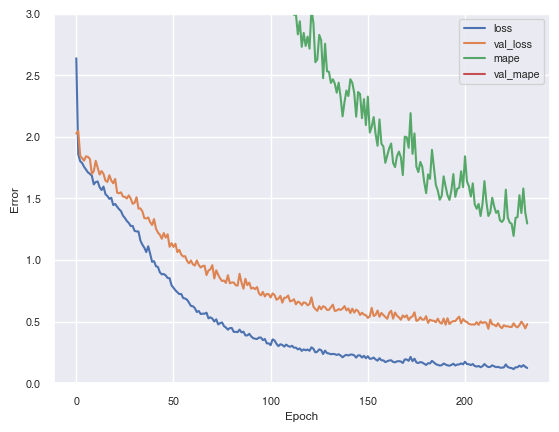

In [46]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['mape'], label='mape')
    plt.plot(history.history['val_mape'], label='val_mape')
    plt.ylim([0, 3])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

### TF block end

In [47]:
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(X_train_sc, y_train)
model_dummy.predict(X_train_sc)
model_dummy.score(X_train_sc, y_train)

-0.02714341944800247

In [48]:
# compare models on test subset

import time

score_list = []
score_list_mape = []
score_list_std_ae = []
time_list = []
models_list = []
r2score_list = []

#### LogisitcRegression

tic = time.time()

model_linear.fit(X_train_sc, y_train)
predictions_logit = model_linear.predict(X_test_sc)

tac = time.time()
time_int = tac - tic 

score_list.append(mean_absolute_error(y_test, predictions_logit))
score_list_mape.append(mean_absolute_percentage_error(y_test, predictions_logit))
score_list_std_ae.append(np.std(abs(y_test - predictions_logit)))
r2score_list.append(r2_score(y_test, predictions_logit))
time_list.append(time_int)
models_list.append('linear')


#### RandomForest

tic = time.time()

best_forest.fit(X_train_sc, y_train)
predictions_forest = best_forest.predict(X_test_sc)

tac = time.time()
time_int = tac - tic 

score_list.append(mean_absolute_error(y_test, predictions_forest))
score_list_mape.append(mean_absolute_percentage_error(y_test, predictions_forest))
score_list_std_ae.append(np.std(abs(y_test - predictions_forest)))
r2score_list.append(r2_score(y_test, predictions_forest))
time_list.append(time_int)
models_list.append('forest')


#### LightGBM

tic = time.time()

lgbm_best_model.fit(X_train_sc, y_train)
predictions_lgbm = lgbm_best_model.predict(X_test_sc)

tac = time.time()
time_int = tac - tic 

score_list.append(mean_absolute_error(y_test, predictions_lgbm))
score_list_mape.append(mean_absolute_percentage_error(y_test, predictions_lgbm))
score_list_std_ae.append(np.std(abs(y_test - predictions_lgbm)))
r2score_list.append(r2_score(y_test, predictions_lgbm))
time_list.append(time_int)
models_list.append('lgbm')


#### Dummy

tic = time.time()

model_dummy.fit(X_train_sc, y_train)
predictions_dummy = model_dummy.predict(X_test_sc)

tac = time.time()
time_int = tac - tic

score_list.append(mean_absolute_error(y_test, predictions_dummy))
score_list_mape.append(mean_absolute_percentage_error(y_test, predictions_dummy))
score_list_std_ae.append(np.std(abs(y_test - predictions_dummy)))
r2score_list.append(r2_score(y_test, predictions_dummy))
time_list.append(time_int)
models_list.append('dummy')

### Sequential
tic = time.time()
predictions_tf = final_model.predict(X_test_sc)

tac = time.time()
time_int = tac - tic

score_list.append(mean_absolute_error(y_test, predictions_tf))
score_list_mape.append(mean_absolute_percentage_error(y_test, predictions_tf))
score_list_std_ae.append(np.std(abs(y_test - predictions_tf.reshape(y_test.shape))))
r2score_list.append(r2_score(y_test, predictions_tf))
time_list.append(time_int)
models_list.append('sequential')



# table for compare results
pd.options.display.float_format = '{:,.4f}'.format  

table_mae = pd.DataFrame(data=[score_list, score_list_mape, score_list_std_ae, r2score_list, time_list], columns=models_list, index=['mae', 'mape', 'std_ae', 'r2score','speed_seconds'])
table_mae = table_mae.T
table_mae = table_mae.sort_values(by='mape', ascending=True)
table_mae['model'] = table_mae.index
table_mae

[LightGBM] [Info] Total Bins 6114
[LightGBM] [Info] Number of data points in the train set: 3770, number of used features: 24
[LightGBM] [Info] Start training from score -10.440849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

mae   mape  std_ae  r2score  speed_seconds       model
lgbm       0.2302 0.0251  0.4657   0.9617         3.9718        lgbm
forest     0.2818 0.0305  0.5140   0.9513         1.7469      forest
sequential 0.4834 0.0525  0.8819   0.8566         0.0749  sequential
linear     1.9997 0.2142  1.3161   0.1874         0.0756      linear
dummy      2.1676 0.2274  1.5711  -0.0161         0.0002       dummy

In [49]:
best_modle_name = list(table_mae['model'].iloc[:1])[0]
print('Best model: ', best_modle_name)

Best model:  lgbm


In [50]:
table_predictions = pd.DataFrame(data=[predictions_logit, predictions_forest, predictions_lgbm, predictions_dummy, predictions_tf.reshape(predictions_forest.shape)], 
                                 index=['linear', 'forest', 'lgbm','dummy', 'sequential'])

table_predictions = table_predictions.T
table_predictions = table_predictions.set_index(y_test.index)
table_predictions['true'] = y_test
table_predictions.head()

linear   forest     lgbm    dummy  sequential     true
1038  -7.3416  -5.0444  -5.0437 -10.0000     -5.0379  -5.0000
136  -10.4502 -14.7556 -14.9876 -10.0000    -14.9282 -15.0000
3763 -10.2290  -9.0444  -8.8542 -10.0000     -9.1794  -9.0000
3397 -10.7083 -10.0889  -9.9558 -10.0000     -9.9681 -10.0000
4134  -6.8038  -7.0000  -6.9087 -10.0000     -6.9087  -7.0000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Points'}, ylabel='Meaning in point'>

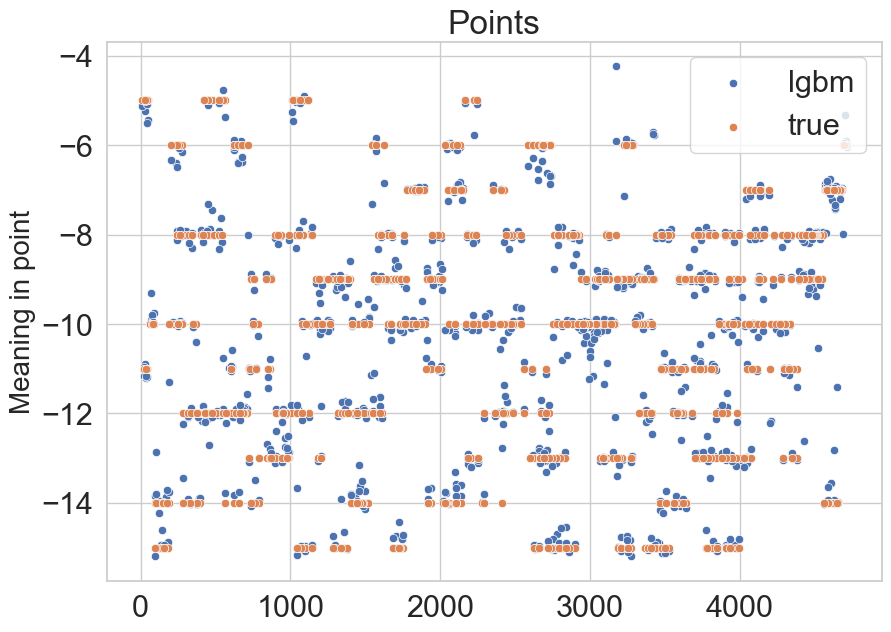

In [51]:
plt.figure(figsize=(10, 7)) 
sns.set(context = 'notebook', style = 'whitegrid', font_scale=2)                      
plt.legend(bbox_to_anchor = (1,1))
plt.ylabel('Meaning in point', fontsize=20)
plt.title('Points')
plt.legend(bbox_to_anchor = (1,1), fontsize=12) 
sns.scatterplot(data = table_predictions, x=table_predictions.index, y=best_modle_name, alpha=1, label=best_modle_name)
sns.scatterplot(data = table_predictions, x=table_predictions.index, y='true', alpha=1, label='true')

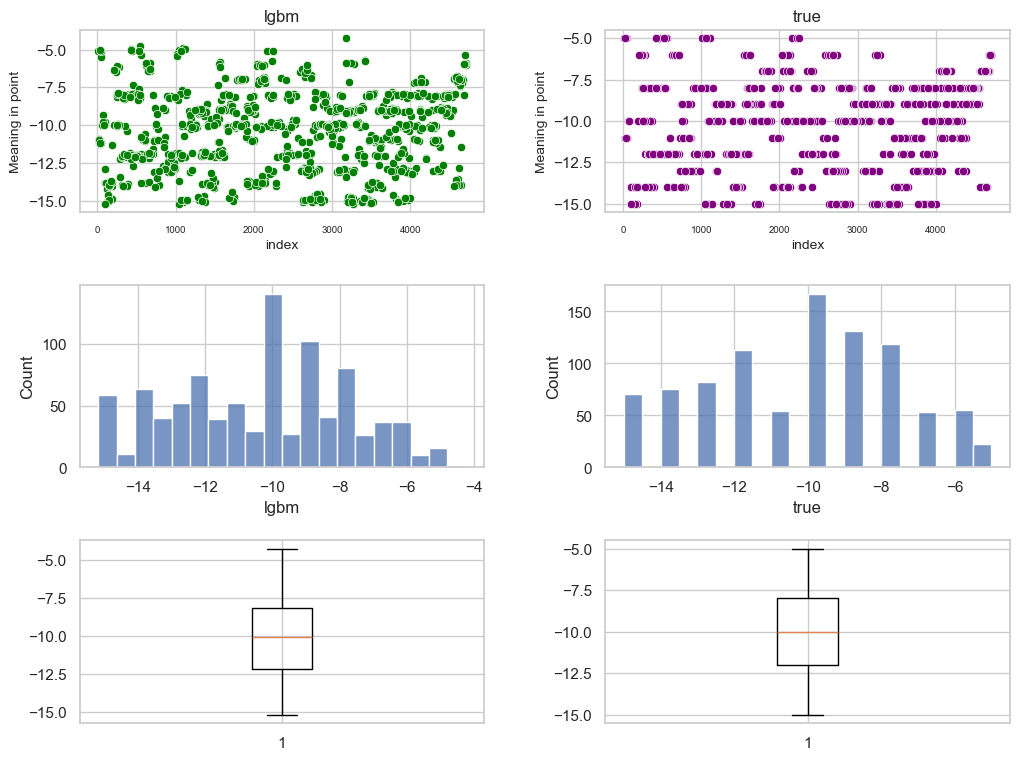

In [52]:
# Compare true values and predictions
plt.figure(figsize=(12, 9)) 
sns.set_theme(context = 'notebook', style = 'whitegrid', font_scale=1)                      


plt.subplot(3, 2, 1)                            
sns.scatterplot(data = table_predictions, x=table_predictions.index, y=best_modle_name, alpha=1, color='green') #label=best_modle_name)
plt.xlabel('index', fontsize=10)
plt.xticks(fontsize = 7, position = (-0.03, 0))#, rotation = 60) 
#plt.ylim(0,upper)
plt.ylabel('Meaning in point', fontsize=10)
plt.title(best_modle_name)


plt.subplot(3, 2, 2)                            
sns.scatterplot(data = table_predictions, x=table_predictions.index, y='true', alpha=1,  color='purple') #label='true')
plt.xlabel('index', fontsize=10)
#plt.ylim(0,upper)
plt.ylabel('Meaning in point', fontsize=10)
plt.xticks(fontsize = 7, position = (-0.03, 0))#, rotation = 60) 
plt.title('true')

plt.subplot(3, 2, 3)    
sns.histplot(table_predictions[best_modle_name], bins=20)
#plt.xlim(0,upper)
#plt.title(best_modle_name)

plt.subplot(3, 2, 4)    
sns.histplot(table_predictions['true'], bins=20)
#plt.xlim(0,upper)
#plt.title('true')


plt.subplot(3, 2, 5)  
plt.boxplot(table_predictions[best_modle_name])  
#plt.ylim(0,upper)

plt.subplot(3, 2, 6)    
plt.boxplot(table_predictions['true'])
#plt.ylim(0,upper)


#plt.legend(bbox_to_anchor = (1,1))
plt.subplots_adjust(hspace = 0.4)
plt.subplots_adjust(wspace = 0.3) 
plt.show()

### Feature importance

-10.440848806365294
[-2.11437744e+13  2.22540672e+11  1.90650595e+12  8.14160093e+09
  4.40294231e+10 -1.13686529e+11 -1.50339065e+10 -1.41527600e+10
 -6.80644497e+08  3.09807508e+11 -8.96000364e+10  6.11851546e+10
  2.11437744e+13 -2.22540672e+11 -1.90650595e+12 -8.14160093e+09
 -4.40294230e+10  1.13686529e+11  1.50339065e+10  1.41527600e+10
  6.80644428e+08 -3.09807508e+11  8.96000364e+10 -6.11851546e+10]


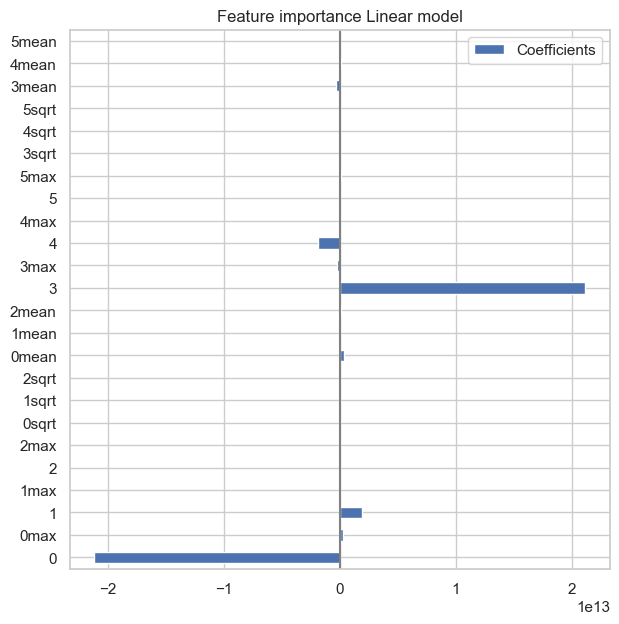

In [53]:
# Feature importance to Linear regression

print(model_linear.intercept_)
print(model_linear.coef_)
a = model_linear.coef_

coefs = pd.DataFrame(
    {"Coefficients": a }, index=X_train_sc.columns
)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Feature importance Linear model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

[1.72949566e+02 1.01973169e+02 8.29498469e+01 5.39173836e+01
 4.22213569e+01 3.38765664e+01 2.40984471e+01 9.16109791e+00
 7.96520022e+00 6.88261086e-01 3.95682652e-01 1.77884278e-13
 1.36558754e-13 6.55265572e-14 5.72549691e-14 4.47843093e-14
 3.15910783e-14 2.10536427e-14 5.87073426e-15 5.11235627e-15
 2.66509509e-15 6.72345440e-16 6.72003371e-16 1.18973535e-28]


<Axes: xlabel='cols', ylabel='values'>

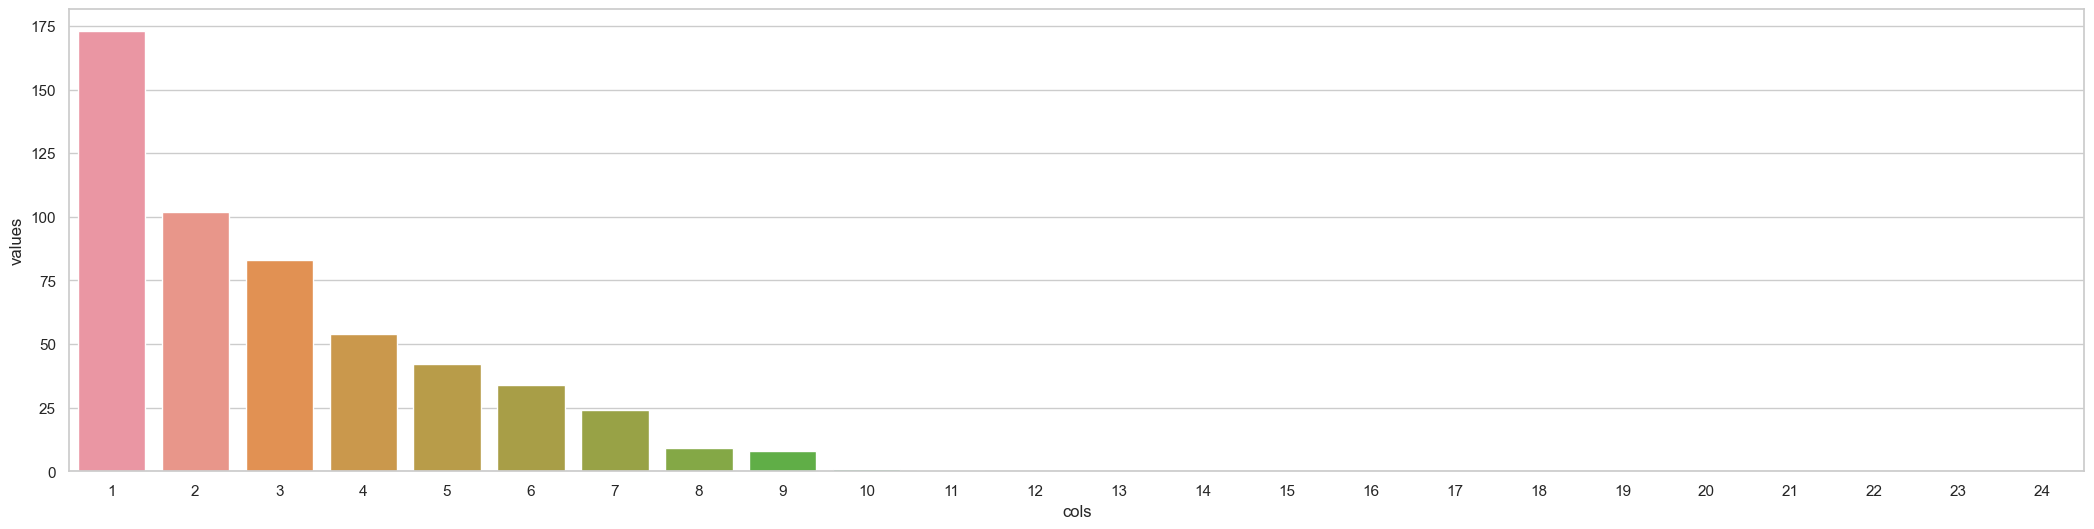

In [54]:
# estimation of importance of axes during PCA (additional task)
n_cols = X_train_sc.shape[1]
pca = PCA(n_cols, random_state=42).fit(X_train_sc.T)
print(pca.singular_values_)


bp = pd.DataFrame({'values': pca.singular_values_, 'cols': range(1, n_cols+1)})

plt.figure(figsize=(26, 6)) 
sns.set_theme(context = 'notebook', style = 'whitegrid', font_scale=1)   
sns.barplot(data=bp, x='cols', y='values')

Text(0.5, 1.0, 'Feature Importance Random forest')

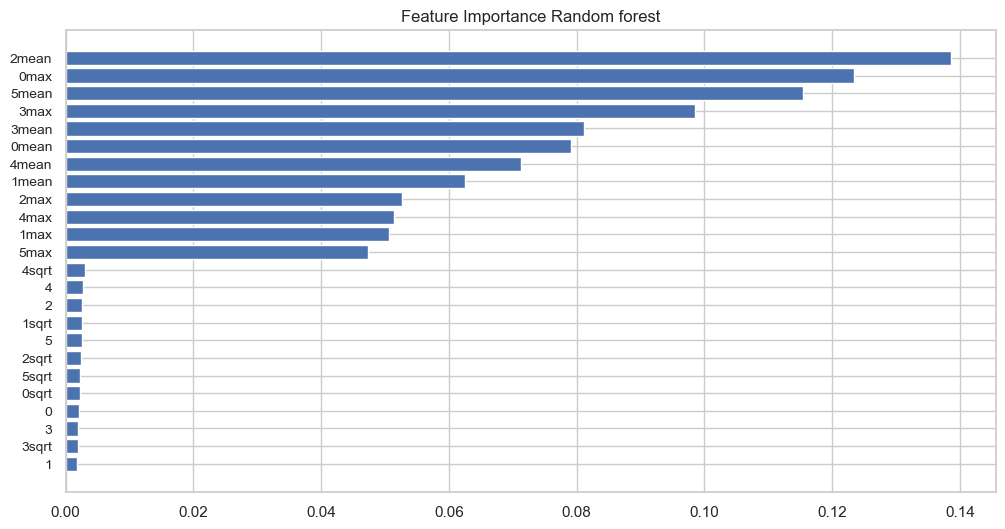

In [55]:
feature_importance = best_forest.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_sc.columns)[sorted_idx], fontsize=10)
plt.title('Feature Importance Random forest')

Text(0.5, 1.0, 'Feature Importance Light GBM')

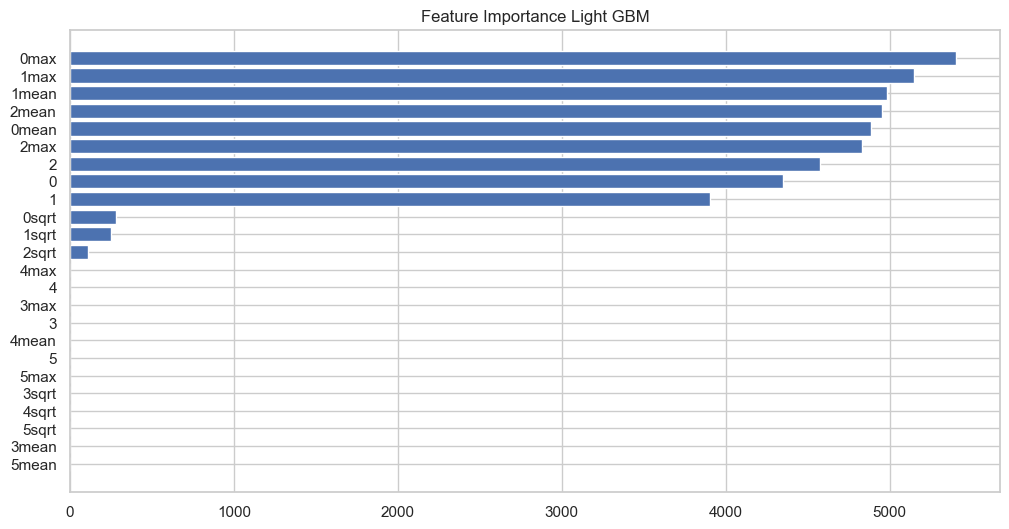

In [56]:
feature_importance = lgbm_best_model.feature_importances_  
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_sc.columns)[sorted_idx])
plt.title('Feature Importance Light GBM')

In [57]:
# Feature importance to Sequential
result = permutation_importance(final_model, X_train_sc_tf, y_train, n_repeats=10, random_state=42, scoring='neg_mean_absolute_percentage_error')

118/118 [==============================] - 0s 317us/step


5mean: 0.151 +/- 0.002
2mean: 0.151 +/- 0.002
0max: 0.124 +/- 0.002
3max: 0.121 +/- 0.002
3mean: 0.119 +/- 0.002
0mean: 0.118 +/- 0.002
2max: 0.116 +/- 0.002
5max: 0.112 +/- 0.002
1mean: 0.108 +/- 0.002
4mean: 0.105 +/- 0.002
1max: 0.098 +/- 0.001
4max: 0.097 +/- 0.001
3sqrt: 0.010 +/- 0.000
0: 0.010 +/- 0.001
3: 0.010 +/- 0.001
5: 0.009 +/- 0.000
0sqrt: 0.009 +/- 0.000
1: 0.008 +/- 0.000
4sqrt: 0.007 +/- 0.001
5sqrt: 0.007 +/- 0.000
2: 0.007 +/- 0.000
2sqrt: 0.006 +/- 0.000
1sqrt: 0.006 +/- 0.000
4: 0.006 +/- 0.000


<Axes: xlabel='importances_mean', ylabel='feature'>

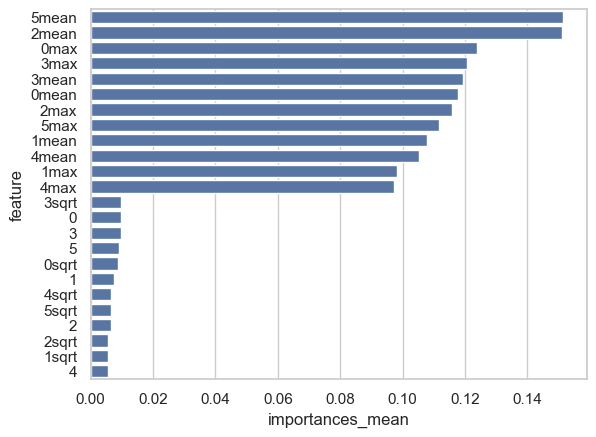

In [58]:
# display results for sequential
for i in result.importances_mean.argsort()[::-1]:
    print(f"{X_train_sc.columns[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

df = pd.DataFrame({'feature':X_train_sc.columns, 'importances_mean': result['importances_mean']})
df = df.sort_values(by='importances_mean', ascending=False)
df
sns.barplot(data=df, x='importances_mean', y='feature', color='b')

# Final prediction

In [59]:
if best_modle_name == 'linear':
    united['depth'] = model_linear.predict(scaler.transform(united.drop(['depth', 'geometry', 'distance_to_coast', 'lat', 'lon'], axis=1)))
elif best_modle_name == 'lgbm':
    united['depth'] = lgbm_best_model.predict(scaler.transform(united.drop(['depth', 'geometry', 'distance_to_coast', 'lat', 'lon'], axis=1)))
elif best_modle_name == 'Sequentail':
    united['depth'] = final_model.predict(scaler.transform(united.drop(['depth', 'geometry', 'distance_to_coast', 'lat', 'lon'], axis=1)))
else:
    united['depth'] = best_forest.predict(scaler.transform(united.drop(['depth', 'geometry', 'distance_to_coast', 'lat', 'lon'], axis=1)))
print('Best model:', best_modle_name)
united.head()

Best model: lgbm


lat     lon          0       0max           1        1max  \
113085 41.7984 41.7600 8,112.0000 8,112.0000 24,117.0000 24,621.0000   
368334 41.7984 41.7602 6,971.0000 8,112.0000 24,325.0000 24,621.0000   
595581 41.7984 41.7603 8,110.0000 8,112.0000 24,095.0000 24,621.0000   
578349 41.7984 41.7605 6,670.0000 8,020.0000 24,169.0000 24,476.0000   
260634 41.7984 41.7607 8,020.0000 8,020.0000 24,217.0000 24,476.0000   

                 2        2max   0sqrt    1sqrt  ...        5max   3sqrt  \
113085 23,651.0000 24,268.0000 90.0666 155.2965  ... 24,268.0000 90.0666   
368334 24,268.0000 24,268.0000 83.4925 155.9647  ... 24,268.0000 83.4925   
595581 23,892.0000 24,268.0000 90.0555 155.2256  ... 24,268.0000 90.0555   
578349 24,054.0000 24,609.0000 81.6701 155.4638  ... 24,609.0000 81.6701   
260634 23,429.0000 24,609.0000 89.5545 155.6181  ... 24,609.0000 89.5545   

          4sqrt    5sqrt      3mean       4mean       5mean    depth  \
113085 155.2965 153.7888 7,732.6667 24,257.3333 23,930.1111 -10.8113   
368334 155.9647 155.7819 7,732.6667 24,257.3333 23,930.1111 -10.9050   
595581 155.2256 154.5704 7,732.6667 24,257.3333 23,930.1111 -11.0063   
578349 155.4638 155.0935 7,168.2222 24,199.4444 24,085.7778 -11.0131   
260634 155.6181 153.0653 7,168.2222 24,199.4444 24,085.7778 -10.4899   

                         geometry  distance_to_coast  
113085  POINT (41.75997 41.79838)           717.8046  
368334  POINT (41.76016 41.79838)           698.4646  
595581  POINT (41.76034 41.79838)           679.1246  
578349  POINT (41.76052 41.79838)           659.7846  
260634  POINT (41.76071 41.79838)           640.4698  

[5 rows x 29 columns]

In [60]:
# function for convert gdf to georaster
def gdf_to_raster(data, param, name='output'):
    # define the resolution and bounds
    data = data.to_crs(data.estimate_utm_crs())
    # set pixel size as required
    pixel_size = 10  
    # get bounds of the geodata
    bounds = data.total_bounds  
    left, bottom, right, top = bounds

    # compute raster width and height
    width = int((right - left) / pixel_size)
    height = int((top - bottom) / pixel_size)

    # define transform
    transform = from_bounds(left, bottom, right, top, width, height)

    # prepare shapes with values
    shapes = ((geom, value) for geom, value in zip(data.geometry, data[param]))

    # rasterize
    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        # background value (for areas without data)
        fill=0,  
        dtype='float32' 
    )

    # metadata for the output raster
    out_meta = {
        'driver': 'GTiff',
        'height': height,
        'width': width,
        'count': 1,
        'dtype': raster.dtype,
        'crs': data.crs,
        'transform': transform,
    }

    # write to GeoTIFF
    with rasterio.open(name + '.tif', 'w', **out_meta) as dest:
        dest.write(raster, 1)

In [61]:
# as my project in EPSG:4326 CRS and output of previous function in other i need to reproject raster

def reproject_raster(path, name_output='output_geographic'):
    input_raster = path  

    # open raster
    with rasterio.open(input_raster) as src:
        # define the target CRS 
        dst_crs = 'EPSG:4326'
    
        # calculate the transform and dimensions for the new raster
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
    
        # update metadata for the output file
        out_meta = src.meta.copy()
        out_meta.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
    # define the output filename 
    output_raster = name_output + '.tif'

    with rasterio.open(input_raster) as src:
        with rasterio.open(output_raster, 'w', **out_meta) as dest:
            # perform the reproject operation
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dest, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest  
            )


In [62]:
# save gdf with depth to raster
gdf_to_raster(united, 'depth', 'depth_modeled')

# finaly sace reprojected raster
reproject_raster('depth_modeled.tif', 'depth_modeled_reproject')